# AICrowd - Hate Speech Detection from tweets [Link](https://www.aicrowd.com/challenges/htspc-hate-speech-classification)

1. Load the data & Load word2vec model
2. Pre-process the data \\
    a. Basic tokenizing, stopwords removal \\
    b. For each tweet, get sentiment analysis \\
    c. For each tweet, do POS tagging and pick the adjectives & adverbs. \\
3. Once we have the sentiment analysis and adjective words for each tweet: \\
    a. Load "n" similar words for the adjective(s). \\
    b. Replace the adjective with the similar word to create more sentences. \\
    c. The label for the sentences will be the same as their parent sentences. \\
    d. Check the sentiment of the new sentences, this will be label_sent. \\
    e. In case of conflict between parent and the label_sent, give priority to label_sent.
4. Now that we have increased the dataset size, we proceed to perform classification using ML Models.

## Google Drive & Imports 

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
%matplotlib inline

!pip install vaderSentiment textstat

     |████████████████████████████████| 133kB 45.4MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 3.0MB 58.2MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt


import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

from time import time
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Input, LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, InputLayer, GlobalMaxPooling1D, GlobalMaxPool1D, GlobalAvgPool1D, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks.callbacks import Callback, EarlyStopping
from keras.regularizers import l2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


## 1. Load the data

In [0]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
VALIDATION_SPLIT = 0.33
EMBEDDING_DIM = 200

EMBEDDING_PATH = "/gdrive/My Drive/Dataset/WordEmbeddings/glove.twitter.27B.200d.txt"

In [0]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

In [0]:
train_data = pd.read_csv("/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv")
test_data = pd.read_csv("/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/fcac6286-6db1-4577-ad80-612fb9d36db9_test.csv")

In [7]:
print(train_data.describe())
train_data.head()

            labels
count  5266.000000
mean      0.614318
std       0.486802
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


,text,labels
0,@realDonaldTrump This is one of the worst time...,0
1,How about the crowd in Oval in today's #AUSvIN...,1
2,@skroskz @shossy2 @JoeBiden Biden &amp; his so...,0
3,#etsy shop: Benedict Donald so called presiden...,1
4,@realDonaldTrump Good build a wall around Arka...,0


In [8]:
def clean_text(line):
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    
    soup = BeautifulSoup(line, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    split = lower_case.split(" ")
    return " ".join(list(filter(None, split))).strip()

def get_indices(x): return np.argmax(x)

train_data["clean_text"] = train_data.text.apply(lambda x: clean_text(x))
train_data.head()

,text,labels,clean_text
0,@realDonaldTrump This is one of the worst time...,0,this is one of the worst times to be american ...
1,How about the crowd in Oval in today's #AUSvIN...,1,how about the crowd in oval in today s ausvind...
2,@skroskz @shossy2 @JoeBiden Biden &amp; his so...,0,biden his son hunter took advantage of their p...
3,#etsy shop: Benedict Donald so called presiden...,1,etsy shop benedict donald so called president ...
4,@realDonaldTrump Good build a wall around Arka...,0,good build a wall around arkansas fucktrump fu...


In [0]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [10]:
embeddings_index = {}
f = open(EMBEDDING_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


# Using Deepnets

Here I use three models 

1. *Regular MLP*
2. *Regular 1D CNN*
3. *Regular LSTM*
4. *Combination network of 1D CNN + LSTM*


In [11]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_data["clean_text"])

sequences = tokenizer.texts_to_sequences(train_data["clean_text"])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train_data["labels"]))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]

x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 13623 unique tokens.
Shape of data tensor: (5266, 200)
Shape of label tensor: (5266, 2)


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## MLP

In [0]:
def mlp_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Flatten())

    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))

    print(model.summary())

    return model

In [14]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)

print("Model used : {}".format("MLP Only"))
mlp = mlp_model()

mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

mlp.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=100, 
          callbacks = [cbacks],
          batch_size=256)

loss, acc = mlp.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, mlp.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))
del mlp

Model used : MLP Only
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
dense_1 (Dense)              (None, 200, 100)          20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 200, 10)           1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 10)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (No

[[350 343]
 [212 832]]


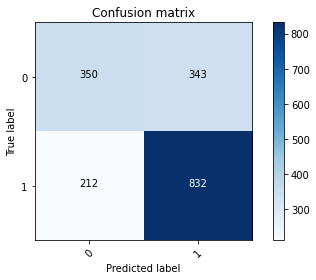

In [15]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 1D CNN

In [0]:
def one_dimensional_cnn():    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    print(model.summary())
    
    return model

In [17]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)
epochs = 100
batch_size = 128

print("Model used : {}".format("CNN Only"))
cnn_model = one_dimensional_cnn()

cnn_model.fit(x_train, y_train, 
              validation_data=(x_val, y_val),
              epochs=epochs,
              callbacks = [cbacks],
              batch_size=batch_size)

loss, acc = cnn_model.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, cnn_model.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : CNN Only
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 32)           19232     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 32)           3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 99, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (No

[[  15  678]
 [   0 1044]]


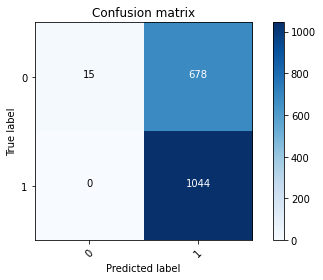

In [18]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## LSTM

In [0]:
def lstm_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    print(model.summary())
    
    return model

In [20]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)
epochs = 100
batch_size = 64

print("Model used : {}".format("LSTM Only"))
lstm = lstm_model()

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc']
)

lstm.fit(x_train, y_train, 
         validation_data=(x_val, y_val),
         epochs=epochs, 
         callbacks = [cbacks],
         batch_size=batch_size
)

loss, acc = lstm.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, lstm.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : LSTM Only
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 30)           27720     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 30)           7320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 200, 30)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 30)           7320      
_________________________________________________________________
dropout_12 (Dropout)         (N

[[307 386]
 [181 863]]


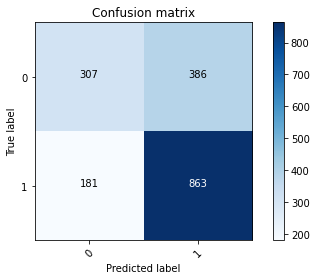

In [21]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## CNN + LSTM

In [0]:
def cnn_lstm():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))

    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))

    print(model.summary())
    
    return model

In [23]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)
epochs = 100
batch_size = 64

print("Model used : {}".format("CNN + LSTM Only"))
cnn_lstm_model = cnn_lstm()

cnn_lstm_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['acc'])

cnn_lstm_model.fit(x_train, y_train, 
                   validation_data=(x_val, y_val),
                   epochs=epochs, 
                   callbacks = [cbacks],
                   batch_size=batch_size)

loss, acc = cnn_lstm_model.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, cnn_lstm_model.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : CNN + LSTM Only
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 197, 128)          102528    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 194, 128)          65664     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 97, 128)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 97, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 94, 128)           65664     
_________________________________________________________________
conv1d_12 (Conv1D)       

[[218 475]
 [159 885]]


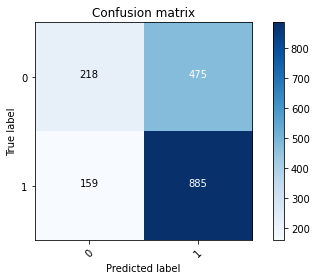

In [24]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Using regular Statistical Models

Load the data, do basic pre-processing and then use a vectorizer to vectorize the data. This data is now ready for Modelling.

### Models used:

1. *Logistic Regression*
2. *Linear SVC*
3. *Multinomial Naive Bayes*
4. *Extra Trees (Usually out performs Random Forest everytime I tried for all other datasets)*

In [0]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

In [0]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [27]:
vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

transformed_data = vectorizer.fit_transform(train_data["text"]).toarray()

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(transformed_data, train_data["labels"], 
                                                    test_size=0.33, stratify=train_data["labels"])
print("Train data stats : {}, {}".format(x_train.shape, y_train.shape))
print("Test data stats : {}, {}".format(x_test.shape, y_test.shape))

Train data stats : (3528, 3473), (3528,)
Test data stats : (1738, 3473), (1738,)


In [30]:
start_time = time()

acc_scores, f1_scores = list(), list()

skf = StratifiedKFold(n_splits=5)
X, y = transformed_data, train_data["labels"]

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb = XGBClassifier(learning_rate=0.05, n_estimators=1300, n_jobs=-1)
    xgb.fit(x_train, y_train)

    preds_xgb = xgb.predict(x_test)
    acc, f1 = accuracy_score(y_test, preds_xgb), f1_score(y_test, preds_xgb)
    print(confusion_matrix(y_test, preds_xgb))
    print("Time taken : {}".format(time() - start_time))
    acc_scores.append(acc * 100)
    f1_scores.append(f1 * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

[[ 92 315]
 [ 82 565]]
Time taken : 232.4322850704193
[[138 268]
 [ 76 571]]
Time taken : 464.51642394065857
[[131 275]
 [ 73 574]]
Time taken : 696.8915908336639
[[115 291]
 [ 75 572]]
Time taken : 929.4188184738159
[[127 279]
 [ 66 581]]
Time taken : 1160.7727811336517
65.82% (+/- 1.90%)
76.09% (+/- 1.14%)


[[127 279]
 [ 66 581]]


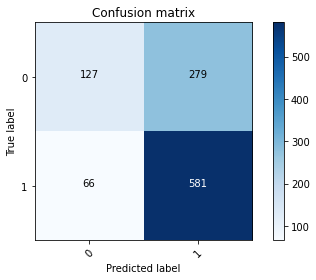

In [31]:
cm = confusion_matrix(y_test, preds_xgb)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [32]:
start_time = time()

acc_scores, f1_scores = list(), list()

skf = StratifiedKFold(n_splits=5)
X, y = transformed_data, train_data["labels"]

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    adaboost = AdaBoostClassifier(learning_rate=0.05, n_estimators=1300)
    adaboost.fit(x_train, y_train)

    preds_adaboost = adaboost.predict(x_test)


    acc, f1 = accuracy_score(y_test, preds_adaboost), f1_score(y_test, preds_adaboost)
    print(confusion_matrix(y_test, preds_adaboost))
    print("Time taken : {}".format(time() - start_time))
    acc_scores.append(acc * 100)
    f1_scores.append(f1 * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

# 75.83 to 77.61

[[ 92 315]
 [ 64 583]]
Time taken : 276.31448912620544
[[126 280]
 [ 54 593]]
Time taken : 607.235383272171
[[122 284]
 [ 74 573]]
Time taken : 894.5337500572205
[[110 296]
 [ 64 583]]
Time taken : 1232.5099534988403
[[114 292]
 [ 54 593]]
Time taken : 1524.3574154376984
66.26% (+/- 1.42%)
76.70% (+/- 0.91%)


[[114 292]
 [ 54 593]]


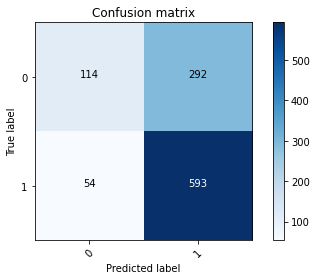

In [33]:
cm = confusion_matrix(y_test, preds_adaboost)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [34]:
start_time = time()

acc_scores, f1_scores = list(), list()

skf = StratifiedKFold(n_splits=5)
X, y = transformed_data, train_data["labels"]

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    et = ExtraTreesClassifier(n_estimators=1300, n_jobs=-1)
    et.fit(x_train, y_train)

    preds_et = et.predict(x_test)
    acc, f1 = accuracy_score(y_test, preds_et), f1_score(y_test, preds_et)
    print(confusion_matrix(y_test, preds_et))
    print("Time taken : {}".format(time() - start_time))
    acc_scores.append(acc * 100)
    f1_scores.append(acc * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

[[171 236]
 [188 459]]
Time taken : 451.1746220588684
[[199 207]
 [160 487]]
Time taken : 757.3827586174011
[[207 199]
 [177 470]]
Time taken : 1122.64852976799
[[199 207]
 [183 464]]
Time taken : 1532.015221118927
[[192 214]
 [173 474]]
Time taken : 1899.1976046562195
63.08% (+/- 1.83%)
63.08% (+/- 1.83%)


[[192 214]
 [173 474]]


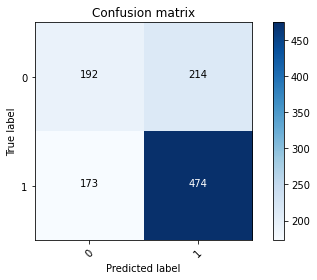

In [35]:
cm = confusion_matrix(y_test, preds_et)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Testing

Check which model gives the best performance and then substitute it in the below code.

In [0]:
def save_submission_stats_models(submission_path, model, test_data):
    preds = model.predict(vectorizer.transform(test_data["text"]))
    pd.DataFrame({"label": preds}).to_csv(submission_path, index=False)

def save_submission_deep_models(submission_path, model, test_data):
    test_data["clean_text"] = test_data.text.apply(lambda x: clean_text(x))

    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(test_data["clean_text"])
    sequences = tokenizer.texts_to_sequences(test_data["clean_text"])
    
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print(F'Shape of data tensor : {data.shape}')

    preds = list(map(get_indices, model.predict(data)))
    pd.DataFrame({"label": preds}).to_csv(submission_path, index=False)

In [0]:
save_submission(model, test_data, submission_path="/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/submission.csv")